# 20160221-predict-household-income-from-census

Related post:  
https://stharrold.github.io/20160221-predict-household-income-from-census.html

Data documentation:
https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html

## Initialization

### Imports

In [1]:
cd ~

/home/samuel_harrold


In [2]:
# Import standard packages.
import collections
import functools
import itertools
import json
import os
import pdb # Debug with pdb.
import pprint
import sys
import time
# Import installed packages.
import astroML.density_estimation as astroML_dens # TODO: remove
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.cross_validation as sk_cv
import sklearn.ensemble as sk_ens
import sklearn.metrics as sk_met
import seaborn as sns
# Import local packages.
# Insert current directory into module search path.
# Autoreload local packages after editing.
# `dsdemos` version: https://github.com/stharrold/dsdemos/releases/tag/v0.0.5
sys.path.insert(0, os.path.join(os.path.curdir, r'dsdemos'))
%reload_ext autoreload
%autoreload 2
import dsdemos as dsd
%matplotlib inline

In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("matplotlib:", mpl.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sk.__version__)
print("dsdemos:", dsd.__version__)

Timestamp:
2016-02-10T05:51:55GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=1, releaselevel='final', serial=0)
matplotlib: 1.5.1
numpy: 1.10.4
pandas: 0.17.1
seaborn: 0.7.0
sklearn: 0.17
dsdemos: 0.0.5


### Globals

File sources:
* 2013 5-year PUMS data dictionary: [PUMS_Data_Dictionary_2009-2013.txt](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2009-2013.txt) (<1&nbsp;MB)
* 2013 5-year PUMS person and housing records for Washington DC:
    * Person records: [csv_pdc.zip](http://www2.census.gov/programs-surveys/acs/data/pums/2013/5-Year/csv_pdc.zip) (5&nbsp;MB compressed, 30&nbsp;MB decompressed)
    * Housing records: [csv_hdc.zip](http://www2.census.gov/programs-surveys/acs/data/pums/2013/5-Year/csv_hdc.zip) (2&nbsp;MB compressed, 13&nbsp;MB decompressed)
* 2013 5-year PUMS estimates for user verification: [pums_estimates_9_13.csv](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/estimates/pums_estimates_9_13.csv) (<1&nbsp;MB)

In [4]:
# State settings.
sns.set() # Set matplot lib styles with seaborn
np.random.seed(seed=0) # Set random state for reproducibility.

# File paths
path_static = os.path.join(os.path.expanduser(r'~'), r'stharrold.github.io/content/static')
basename = r'20160221-predict-household-income-from-census'
filename = basename
path_ipynb = os.path.join(path_static, basename, filename+'.ipynb')
path_disk = os.path.abspath(r'/mnt/disk-20151227t211000z/')
path_acs = os.path.join(path_disk, r'www2-census-gov/programs-surveys/acs/')
path_dtxt = os.path.join(path_acs, r'tech_docs/pums/data_dict/PUMS_Data_Dictionary_2009-2013.txt')
path_pcsv = os.path.join(path_acs, r'data/pums/2013/5-Year/ss13pdc.csv') # 'pdc' = 'person DC'
path_hcsv = os.path.join(path_acs, r'data/pums/2013/5-Year/ss13hdc.csv') # 'hdc' = 'housing DC'

# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

## Extract, transform, and load

Related post:  
https://stharrold.github.io/20160110-etl-census-with-python.html

### Data dictionary

In [5]:
print("`ddict`: Load the data dictionary.")
ddict = dsd.census.parse_pumsdatadict(path=path_dtxt)

`ddict`: Load the data dictionary.


### PUMS data

**TODO:**
* Useful link: For learning and testing regular expressions: http://regexr.com/
* Useful link: For comparing SQL and pandas 'JOIN' operations: http://pandas.pydata.org/pandas-docs/stable/merging.html


`df_ftrs`, `ds_trg`, `df_wts`, `df_pwt`: Load and join person and housing records
to make data frames (series) of features, targets, and weights.
Join records on 'SERIALNO'. Only keep household records for which there are person records.

Number of (rows, columns):
`df_ftrs`:
    Number of (rows, columns) = (30559, 282)
    RAM usage (MB) = 68.9
`ds_trg`:
    Number of (rows, columns) = (30559,)
    RAM usage (MB) = 0.2
`df_wts`:
    Number of (rows, columns) = (30559, 162)
    RAM usage (MB) = 39.6

Describe target variable.
target: HINCP
    length: 8
    description: Household income (past 12 months)
    var_codes:
        bbbbbbbb: N/A(GQ/vacant)
        00000000: No household income
        -0059999: Loss of -$59,999 or more
        -0000001..-0059998: Loss of $1 to -$59,998
        00000001: $1 or Break even
        00000002..99999999: Total household income in dollars (Components are rounded)
    notes: ['Note: Use values from ADJINC to adjust HINCP to constant dollars.']


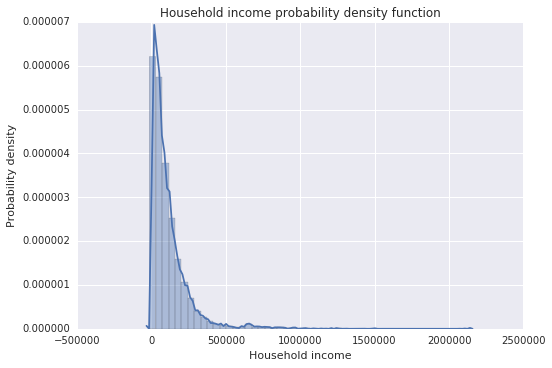

Statistical summary:
count      30559.000000
mean      113897.186983
std       145755.237279
min       -14762.351200
5%             0.000000
15.9%      10146.381300
50%        72128.180000
84.1%     200160.431100
95%       356467.362800
max      2138939.169000
Name: HINCP, dtype: float64

First 10 shuffled records:
16331    105461.4000
13377         0.0000
21799         0.0000
12686     63276.8400
18404    432502.3140
23703     27466.9716
17097     68549.9100
22590    199852.9650
16210    189935.9814
16965     36911.4900
Name: HINCP, dtype: float64

Time elapsed (sec) = 4.1


In [64]:
print(
    r"""`df_ftrs`, `ds_trg`, `df_wts`, `df_pwt`: Load and join person and housing records
to make data frames (series) of features, targets, and weights.
Join records on 'SERIALNO'. Only keep household records for which there are person records.""")
print()
time_start = time.perf_counter()

# Load and join person and housing CSVs. Join on 'SERIALNO'.
# Only keep households for which there are person records.
# Note: For ss13pdc.csv, low_memory=False since otherwise pandas raises DtypeWarning.
dfp = pd.read_csv(path_pcsv, low_memory=False)
dfh = pd.read_csv(path_hcsv, low_memory=True)
if not len(dfh) == len(dfh['SERIALNO'].unique()):
    raise AssertionError(
        ("Program error. All household records must be unique.\n" +
         "Required: len(dfh) == len(dfh['SERIALNO'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(dfh), rhs=len(dfh['SERIALNO'].unique())))
# Join (merge) person and housing records on 'SERIALNO'.
# Include a column with standardized white noise as a lower bound for feature importance.
df = pd.merge(left=dfp, right=dfh, how='left', on='SERIALNO', suffixes=('_p', '_h'))
rnd = ['random_'+str(idx) for idx in range(5)]
for col in rnd:
    df[col] = np.random.standard_normal(size=len(df))
# Assert all records identify people.
if not len(df) == len(dfp):
    raise AssertionError(
        ("Program error. All records must identify people.\n" +
         "Required: len(df) == len(dfp)\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df), rhs=len(dfp)))    
# Assert that shared columns have same values then delete
# except for record type 'RT'.
shared_cols = set(dfp.columns.values)
shared_cols.intersection_update(dfh.columns.values)
suffixed_cols = collections.defaultdict(list)
for col in df.columns:
    (base, *suffix) = col.rsplit(sep='_', maxsplit=1)
    if (((suffix == ['p']) or (suffix == ['h']))
        and (base in shared_cols)):
        suffixed_cols[base].append(col)
for (col, (colp, colh)) in suffixed_cols.items():
    if np.all(df[colp] == df[colh]):
        df[col] = df[colp]
        df.drop(labels=[colp, colh], axis=1, inplace=True)
    elif col == 'RT':
        df[col] = df[colp]
        df.drop(labels=[colp, colh], axis=1, inplace=True)
    else:
        raise AssertionError(
            ("Program error. All shared columns must have the same values\n" +
             "before deleting, except for record type 'RT'.\n" +
             "Required: np.all(df[colp] == df[colh])\n" +
             "colp = {colp}\n" +
             "colh = {colh}").format(colp=colp, colh=colh))
# Replace string values and cast all types to float.
obj_cols = df.dtypes[df.dtypes == 'object'].index
for col in obj_cols:
    # 'RT' record types.
    if 'RT' in col:
        df[col] = df[col].apply(ord)
    # 'SOC' occupational codes.
    if 'SOCP' in col:
        df[col] = df[col].str.replace('X', '0')
        df[col] = df[col].str.replace('Y', '0')
        df[col] = df[col].replace(
            to_replace=r'N\.A\.(\/\/)?', value=0, inplace=False, regex=True)
    # 'OCC' occupational codes.
    if 'OCCP' in col:
        df[col] = df[col].replace(
            to_replace=r'N\.A\.(\/\/)?', value=0, inplace=False, regex=True)
    # 'NAICSP' industry codes.
    if 'NAICSP' in col:
        df[col] = df[col].str.replace(r'\D', '0')
        ndigits = df[col].apply(lambda obj: len(str(obj))).max()
        df[col] = df[col].str.ljust(ndigits, '0')
    df[col] = df[col].astype(float)
df = df.astype(float)
df.fillna(value=0.0, inplace=True)
# Adjust for inflation to 2013-dollars.
# The adjustment factors have 6 implied decimal places.
# See the data dictionary description for
#     'ADJHSG' (only housing records)
#     'ADJINC' (in housing and person records).
# Example: USD_2013 = ADJINC_2010_TO_2013 * USD_2010
# Note: 'INSP' is not in data dictionary, so don't use.
df['ADJHSG'] *= 1e-6
adjhsg_cols = [
    'CONP', 'ELEP', 'FULP', 'GASP', 'GRNTP', 'MHP',
    'MRGP', 'SMOCP', 'RNTP', 'SMP', 'WATP']
for col in adjhsg_cols:
    df[col] *= df['ADJHSG']
df['ADJINC'] *= 1e-6
adjinc_cols = [
    'INTP', 'OIP', 'PAP', 'PERNP', 'PINCP', 'RETP',
    'SEMP', 'SSIP', 'SSP', 'WAGP', 'FINCP', 'HINCP']
for col in adjinc_cols:
    df[col] *= df['ADJINC']
# Shuffle all rows.
df = df.iloc[np.random.permutation(np.arange(len(df.index)))]

# Define columns.
# Define columns for weights.
pwt = 'PWGTP' # person weight
pwts = [pwt+str(inum) for inum in range(1, 81)]
hwt = 'WGTP' # housing weight
hwts = [hwt+str(inum) for inum in range(1, 81)]
wts = [pwt] + pwts + [hwt] + hwts
# Define column for target: household income.
trg = 'HINCP'
# Define columns to exclude.
# Note:
#     * Individually listed columns were selected from descriptions.
#     * Because this example is for predicting household income,
#         exclude all columns that must be adjusted for inflation.
#         These are often related to income.
#     * Because the application is predicting household income,
#         exclude obviously highly predictive features such as
#         'POVPIP' = income-to-poverty ratio or 'TAXP' = property taxes.
#         See the `feature_importances_` attribute of the estimator below.
#     * Exclude columns that don't have a clear interpretation,
#         e.g. 'SRNT' = "specified rent unit".
#     * Excluded flag version of excluded columns.
exc = [trg] + adjhsg_cols + adjinc_cols + [
    'POVPIP', 'TAXP', 'OCPIP', 'VALP', 'GRPIP', 'VEH',
    'MRGX', 'MRGT', 'MRGI', 'SMX', 'SRNT', 'SVAL']
exc += ['F'+col for col in exc]
# Define columns for features.
# Select columns from person and household records that...
#     ...are in the data dictionary
#     ...aren't weights
#     ...are in the person/housing CSVs
#     ...are not an excluded column
#     ...and include the random benchmark columns
# Remove duplicate columns.
# Shuffle feature columns.
ftrs = set(
    list(ddict['record_types']['PERSON RECORD'].keys())
    + list(ddict['record_types']['HOUSING RECORD'].keys()))
ftrs.difference_update(wts)
ftrs.intersection_update(df.columns.values)
ftrs.difference_update(exc)
ftrs.update(rnd)
ftrs = np.random.permutation(list(ftrs))
if trg in ftrs:
    raise AssertionError(
        ("Program error. Target column (`trg`) is in features (`ftrs`).\n" +
         "trg = {trg}").format(trg=trg))

# Separate data frame into features, target, weights.
df_ftrs = df[ftrs]
ds_trg = df[trg]
df_wts = df[wts]
ds_pwt = df[pwt]
print("Number of (rows, columns):")
for (name, obj) in [
    ('df_ftrs', df_ftrs), ('ds_trg', ds_trg), ('df_wts', df_wts)]:
    print("`{name}`:".format(name=name))
    print("    Number of (rows, columns) = {tup}".format(
        tup=np.shape(obj)))
    if isinstance(obj, pd.DataFrame):
        print("    RAM usage (MB) = {mem:.1f}".format(
            mem=obj.memory_usage().sum()/1e6))
    elif isinstance(obj, pd.Series):
        print("    RAM usage (MB) = {mem:.1f}".format(
            mem=obj.memory_usage()/1e6))
print()

print("Describe target variable.")
print("target: {trg}".format(trg=trg))
for (key0, val0) in ddict['record_types']['HOUSING RECORD'][trg].items():
    if isinstance(val0, dict):
        print("    {key}:".format(key=key0))
        for (key1, val1) in val0.items():
            print("        {key}: {val}".format(key=key1, val=val1))
    else:
        print("    {key}: {val}".format(key=key0, val=val0))
incomes = list()
for tup in zip(ds_trg.values, ds_pwt.astype(int)):
    incomes += itertools.repeat(*tup)
if not len(incomes) == ds_pwt.sum():
    raise AssertionError(
        ("Program error. The total number of incomes equal the sum of the weights.\n" +
         "Required: len(incomes) == ds_pwt.sum()\n" +
         "Given: {lhs} == {rhs}").format(lhs=len(incomes), rhs=ds_pwt.sum()))
sns.distplot(incomes, hist=True, kde=True, norm_hist=True)
plt.title('Household income probability density function')
plt.xlabel('Household income')
plt.ylabel('Probability density')
plt.show()
print("Statistical summary:")
print(ds_trg.describe(percentiles=percentiles))
print()
print("First 10 shuffled records:")
print(ds_trg.head(n=10))
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

## Select features

**TODO:**
* Task is to use only marginally informative features.

In [65]:
n_subset = int(1e4)
(ftrs_train, ftrs_test,
 trg_train, trg_test,
 pwt_train, pwt_test) = sk_cv.train_test_split(
    df_ftrs.values[:n_subset], ds_trg.values[:n_subset], ds_pwt.values[:n_subset], test_size=0.2)

In [66]:
# Note: n_estimators impact the feature importances but only have a small effect on the relative importances.  
estimator = sk_ens.ExtraTreesRegressor(n_estimators=10, n_jobs=-1)
estimator.fit(X=ftrs_train, y=trg_train, sample_weight=pwt_train)
estimator.score(X=ftrs_test, y=trg_test, sample_weight=pwt_test)

0.47093959726045315

In [67]:
for (score, col) in sorted(zip(estimator.feature_importances_, df_ftrs.columns.values), reverse=True):
    try:
        desc = ddict['record_types']['PERSON RECORD'][col]['description']
    except KeyError:
        if col in rnd:
            desc = 'Random standardized white noise'
        else:
            desc = ddict['record_types']['HOUSING RECORD'][col]['description']
    print("{score:.4f},\t{col},\n\t{desc}".format(
            score=score, col=col, desc=desc))

0.1329,	RMSP,
	Number of Rooms
0.0868,	RACWHT,
	White recode (White alone or in combination with one or more other races)
0.0480,	BDSP,
	Number of bedrooms
0.0344,	WIF,
	Workers in family during the past 12 months
0.0220,	RACBLK,
	Black or African American recode (Black alone or in combination with one or more other races)
0.0204,	SCIENGRLP,
	Field of degree science and engineering related flag - NSF definition
0.0188,	YBL,
	When structure first built
0.0182,	BUS,
	Business or medical office on property
0.0180,	RNTM,
	Meals included in rent
0.0158,	TEN,
	Tenure
0.0145,	WKHP,
	Usual hours worked per week past 12 months
0.0139,	HINS1,
	Insurance through a current or former employer or union
0.0129,	BLD,
	Units in structure
0.0127,	HHT,
	Household/family type
0.0114,	NP,
	Number of person records following this housing record
0.0112,	WKEXREL,
	Work experience of householder and spouse
0.0104,	SCIENGP,
	Field of degree science and engineering flag - NSF definition
0.0100,	NR,
	Presence of 

In [54]:
np.mean(estimator.feature_importances_)

0.0035971223021582736

In [ ]:
# TODO: resume here 20160210
# * Create lat-lon mapping of PUMAs.
# * Select features with more than highest random importance.
# * Check that spark mlib has this kind of random forest implementation.
# * Tune hyperparameters. Experiment with 'bootstrap' and 'oob_score'.
# * Make into a pipeline.
# * Cross-validate scores of predicted household income.
# * Plot predicted vs actual.
# * Plot marginalized importances.

In [72]:
ddict['record_types']['PERSON RECORD']['FOD1P']

OrderedDict([('length', '4'),
             ('description', 'Recoded field of degree - first entry'),
             ('var_codes',
              OrderedDict([('bbbb', "N/A (less than bachelor's degree)"),
                           ('1100', 'GENERAL AGRICULTURE'),
                           ('1101', 'AGRICULTURE PRODUCTION AND MANAGEMENT'),
                           ('1102', 'AGRICULTURAL ECONOMICS'),
                           ('1103', 'ANIMAL SCIENCES'),
                           ('1104', 'FOOD SCIENCE'),
                           ('1105', 'PLANT SCIENCE AND AGRONOMY'),
                           ('1106', 'SOIL SCIENCE'),
                           ('1199', 'MISCELLANEOUS AGRICULTURE'),
                           ('1301', 'ENVIRONMENTAL SCIENCE'),
                           ('1302', 'FORESTRY'),
                           ('1303', 'NATURAL RESOURCES MANAGEMENT'),
                           ('1401', 'ARCHITECTURE'),
                           ('1501', 'AREA ETHNIC AND CIVILIZATION STU

In [30]:
scores = list()
for n_estimators in n_estimators_list:
    time_start = time.perf_counter()
    print("n_estimators={nest}".format(nest=n_estimators), end='; ')
    estimator = sk_ens.ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=n_jobs)
    estimator.fit(X=df_ftrs_train, y=df_trg_train, sample_weight=ds_pwt_train)
    
    sk_met.r2_score(y_true=ds_trg, y_pred=)
    score = np.mean(sk_cv.cross_val_score(
        estimator=estimator, X=df_ftrs, y=ds_trg, scoring='r2', cv=2, n_jobs=n_jobs))
    scores.append(score)
    print("score={scr:.3f}".format(scr=score))
    time_stop = time.perf_counter()
    print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

n_estimators=30; 

KeyboardInterrupt: 

In [39]:
test = sk_cv.train_test_split(df_ftrs, ds_trg, test_size=0.2)
np.shape(test[0]), np.shape(test[1])

((24447, 332), (6112, 332))

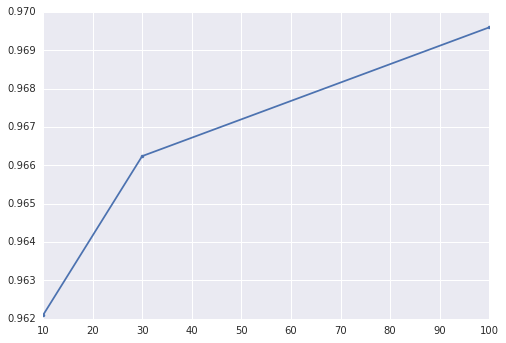

In [28]:
plt.plot(n_estimators_list, scores, marker='.')
plt.show()

In [ ]:
n_jobs = -1
estimator = functools.partial(sk_ens.ExtraTreesRegressor, {'n_jobs': n_jobs})
score = sk_cv.cross_val_score(
    estimator=estimator, X=df_ftrs, y=ds_trg, scoring='r2', cv=5, n_jobs=n_jobs)
score

In [ ]:
model = sk_ens.ExtraTreesRegressor()
model.fit(X=df_ftrs, y=ds_trg)

In [ ]:
model = sk.feature_selection.SelectFromModel(
    estimator=sk_ens.ExtraTreesRegressor(), threshold='mean', prefit=False)
model.fit()

In [ ]:
# TODO: test significance of score
# http://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html

# TODO: redo below

## Select features

**Notes:**
* Example consumer databases: http://www.consumerreports.org/cro/money/consumer-protection/big-brother-is-watching/overview/index.htm?rurl=http%3A%2F%2Fwww.consumerreports.org%2Fcro%2Fmoney%2Fconsumer-protection%2Fbig-brother-is-watching%2Foverview%2Findex.htm
* Random forests are scale invariant, so they can accommodate non-linear transformation.
* Cast all values to floats so that compatable with most algorithms and can use </> logic. Otherwise less informationally dense and may require deeper tree structure to find features.
* To "map to float" ('b' is N/A, mapped to 0; 1 is Yes; 2 is No; other values are special):  
```python
test = pd.DataFrame(data=[['  b', 1.0], ['1', 1.0], ['2', 1.0], ['3', 1.1], ['4', 1.1]], columns=['COL', 'ADJ'])
tfmask = test['COL'].str.contains('b')
test.loc[tfmask, 'COL'] = 0.0
test['COL'] = test['COL'].astype(float)
print(test.dtypes)
test
```
* To "adjust for inflation":  
```python
test['ADJ'] *= 1e-6
tfmask = test['COL'] >= 3.0
test.loc[tfmask, 'COL'] *= test.loc[tfmask, 'ADJ']
test
```
* TODO: Remove vacant units ('NP') from data frame.
* TODO: Filter categorical variables from metadata (those without '..').

In [66]:
record_type = 'PERSON RECORD'
print_detail = False
for key in ddict['record_types'][record_type]:
    desc = ddict['record_types'][record_type][key]['description']
    if not (
        (key.startswith('F') and (desc.endswith(' flag') or desc.endswith(' edit')))
        or ('WGTP' in key and "Weight replicate" in desc)):
        if print_detail:
            print(key)
            pprint.pprint(ddict['record_types'][record_type][key])
        else:
            print("{key}: {desc}".format(key=key, desc=desc))

RT: Record Type
SERIALNO: Housing unit/GQ person serial number
SPORDER: Person number
PUMA00: Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.
PUMA10: Public use microdata area code (PUMA) based on 2010 Census definition for data Collected in 2012 or later. Use in combination with PUMA00.
ST: State Code
ADJINC: Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
PWGTP: Person's weight
AGEP: Age
CIT: Citizenship status
CITWP05: Year of naturalization write-in for data collected prior to 2012
CITWP12: Year of naturalization write-in for data collected in 2012 or later
COW: Class of worker
DDRS: Self-care difficulty
DEAR: Hearing difficulty
DEYE: Vision difficulty
DOUT: Independent living difficulty
DPHY: Ambulatory difficulty
DRAT: Veteran service connected disability rating (percentage)
DRATX: Veteran service connected disability rating (checkbox)
DREM: Cognitive diffic

In [85]:
# Include columns that I think companies can easily get.
# for column details: https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html
# target: HINCP

cols_include = {
    'HOUSING RECORD': [
        'SERIALNO', 'PUMA00', 'PUMA10', 'ST', 'ADJHSG', 'ADJINC', 'WGTP', 'NP', 'BDSP', 'BLD', 'HINCP', 'R18', 'R65'],
    'PERSON RECORD': [
        'SERIALNO', 'SPORDER', 'PWGTP', 'AGEP', 'MAR', 'SCHL', 'INDP']
    }

In [86]:
for record_type in cols_include:
    print(record_type)
    for var_name in cols_include[record_type]:
        desc = ddict['record_types'][record_type][var_name]['description']
        print("{var}: {desc}".format(var=var_name, desc=desc))
    print()

HOUSING RECORD
SERIALNO: Housing unit/GQ person serial number
PUMA00: Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.
PUMA10: Public use microdata area code (PUMA) based on 2010 Census definition for data collected in 2012 or later. Use in combination with PUMA00.
ST: State Code
ADJHSG: Adjustment factor for housing dollar amounts (6 implied decimal places)
ADJINC: Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
WGTP: Housing Weight
NP: Number of person records following this housing record
BDSP: Number of bedrooms
BLD: Units in structure
HINCP: Household income (past 12 months)
R18: Presence of persons under 18 years in household (unweighted)
R65: Presence of persons 65 years and over in household (unweighted)

PERSON RECORD
SERIALNO: Housing unit/GQ person serial number
SPORDER: Person number
PWGTP: Person's weight
AGEP: Age
MAR: Marital status
SCHL: Educational

In [80]:
record_type = 'PERSON RECORD'
var_codes = ddict['record_types'][record_type]['INDP']['var_codes']
indp_abbr = dict()
for var_code in var_codes.keys():
    indp_abbr[var_code] = var_codes[var_code].split(sep='-', maxsplit=1)[0][:3]
print(sorted(set(indp_abbr.values())))

['ADM', 'AGR', 'CON', 'EDU', 'ENT', 'EXT', 'FIN', 'INF', 'MED', 'MFG', 'MIL', 'Not', 'PRF', 'RET', 'SCA', 'SRV', 'TRN', 'UNE', 'UTL', 'WHL']


Actions for included columns:  
* HOUSING RECORD
    * SERIALNO: Use to join to PERSON RECORD.
    * PUMA00, PUMA10, ST: Combine and lookup lat-lon coordinates from census.gov.
    * ADJHSG, ADJINC: Multiply against other columns to adjust for inflation. See https://www.census.gov/library/publications/2009/acs/pums.html App 5.
    ADJHSG: CONP, ELEP, FULP, GASP, GRNTP, INSP, MHP, MRGP, SMOCP, RNTP, SMP, WATP
    ADJINC: INTP, OIP, PAP, PERNP, PINCP, RETP, SEMP, SSIP, SSP, WAGP
    * WGTP: Confirm with user verification file.
    * NP: Numerical. Map to float.
    * BDSP: Numerical. Map to float.
    * BLD: Map to median income.
    * HINCP: Include. Map household income to float. Adjust all with ADJINC.
    * R18: Include. Presence of persons under 18 years in household. Map to float.
    * R65: Include. Presence of persons 60+ years in household.
* PERSON RECORD
    * SERIALNO, SPORDER: Use as index.
    * PWGTP: Confirm user verification file.
    * AGEP: Map to float.
    * MAR: Map to float.
    * SCHL: Map to float.
    * INDP: (1) Map to float. (2) Map categories to median income.

## Export ipynb to html

In [158]:
!date --rfc-3339='seconds'

2016-01-01 05:40:17+00:00


In [ ]:
path_ipynb = os.path.join(path_static, basename, basename+'.ipynb')
for template in ['basic', 'full']:
    path_html = os.path.splitext(path_ipynb)[0]+'-'+template+'.html'
    cmd = ['jupyter', 'nbconvert', '--to', 'html', '--template', template, path_ipynb, '--output', path_html]
    print(' '.join(cmd))
    subprocess.run(args=cmd, check=True)